In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
# Load the data
genotypes = pd.read_csv('tomatoes/Genotypic_data_maf10_min10_291acc.txt', index_col=0)
phenotype = pd.read_csv('tomatoes/phenodata_BLUP_2012.txt', sep='\t', index_col='ID')

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    genotypes, phenotype['FREAR'], test_size=0.2, random_state=42)

In [6]:
# Function to calculate minor allele frequency
def calculate_maf(df):
    maf = df.apply(lambda x: min(x.mean(), 1 - x.mean()), axis=0)
    return maf

# Function for LD pruning
def ld_pruning(df, threshold=0.5):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # Updated to use bool
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis=1)

In [7]:
# Apply MAF and LD pruning only to the training set
maf = calculate_maf(X_train)
X_train_filtered = X_train.loc[:, maf > 0.05]  # Filter out SNPs with MAF <= 5%
X_train_pruned = ld_pruning(X_train_filtered)

In [8]:
# Impute missing data and scale the data
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_pruned), columns=X_train_pruned.columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_pruned.columns)

# Apply the same imputation and scaling transformations to the test set
X_test_filtered = X_test[X_train_pruned.columns]  # Keep only the columns that survived pruning
X_test_imputed = pd.DataFrame(imputer.transform(X_test_filtered), columns=X_train_pruned.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_train_pruned.columns)

In [9]:
# Define hyperparameters grid
gb_params = {
    'n_estimators': [100, 200, 300, 400, 500],  # Increasing number of trees
    'max_depth': [3, 5, 10, None],              # Varying max depth of the trees
    'learning_rate': [0.01, 0.1, 0.2]           # Varying learning rate
}

# Randomized search with cross-validation
gb_random_search = RandomizedSearchCV(GradientBoostingRegressor(random_state=0),
                                      gb_params,
                                      n_iter=50,  # Increased number of parameter settings sampled
                                      cv=5,
                                      verbose=2,
                                      random_state=0)
gb_random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=None, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=None, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=None, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=None, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=None, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=None, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=None, n_e

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
                   n_iter=50,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 10, None],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=0, verbose=2)

In [10]:
# Extracting best estimator and its features
best_gb = gb_random_search.best_estimator_
selected_features = X_train_scaled.columns[best_gb.feature_importances_ > np.percentile(best_gb.feature_importances_, 75)]


In [11]:
# Export selected features
pd.Series(selected_features).to_csv('selected_features_gradient_boosting.csv', index=False)


In [12]:
# Using selected features for modeling
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

In [13]:
# Linear regression for prediction
regressor = LinearRegression()
regressor.fit(X_train_selected, y_train)
y_pred = regressor.predict(X_test_selected)


In [14]:
# Calculate RMSE and R-squared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)



In [15]:
print(f'Test RMSE: {rmse}')
print(f'Test R²: {r2}')
# Output the best RMSE found during cross-validation
print("Best cross-validated RMSE: ", -gb_random_search.best_score_)  # Negate to get the positive RMSE

Test RMSE: 2.1913427290816663
Test R²: 0.3217879703305182
Best cross-validated RMSE:  -0.2443028204688787


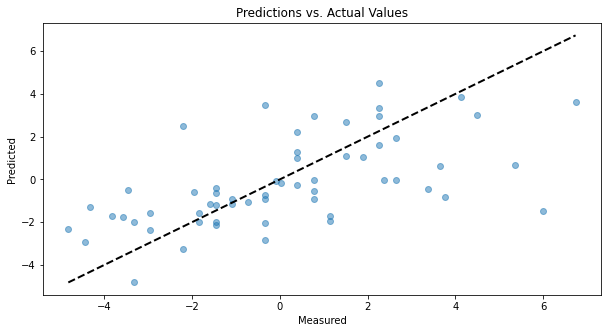

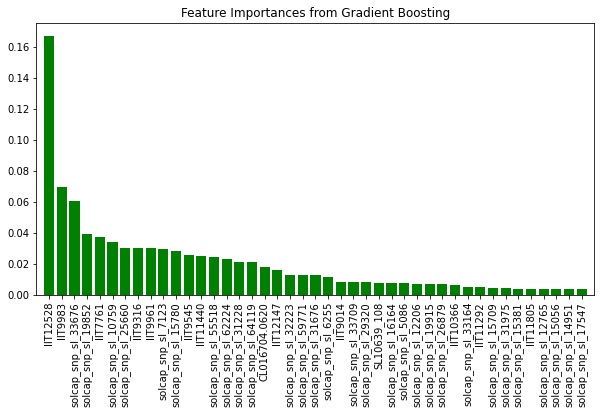

In [16]:
# Visualization of predictions vs. actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predictions vs. Actual Values')
plt.show()

# Plot feature importances of the selected features only
plt.figure(figsize=(10, 5))
# Get importances for selected features only
selected_importances = best_gb.feature_importances_[best_gb.feature_importances_ > np.percentile(best_gb.feature_importances_, 75)]
# Sort features by importance
sorted_idx = np.argsort(selected_importances)[::-1]

plt.title('Feature Importances from Gradient Boosting')
# Here, ensure that the range and selected_importances align properly
plt.bar(range(len(selected_importances)), selected_importances[sorted_idx], color="g", align="center")
# Use selected_features to label x-ticks
plt.xticks(range(len(selected_importances)), selected_features[sorted_idx], rotation=90)
plt.xlim([-1, len(selected_importances)])
plt.show()